In [23]:
import umap

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils.class_weight import compute_sample_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/ACCIDENT_LEVEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(440127, 75)


,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,...,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,is_toll
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,...,2,2015,1,5,1,1,9,0,1,0
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,...,2,2015,1,4,1,0,14,0,0,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,...,1,2015,1,4,1,0,17,0,1,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,...,1,2015,1,5,1,1,19,0,0,0
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,...,3,2015,1,4,1,0,21,0,0,0


In [3]:
df.columns

Index(['REGION', 'DATE', 'COORD_L', 'COORD_W', 'road_name', 'road_category',
       'n_VEHICLES', 'n_PARTICIPANTS', 'ID', 'n_DEATHS', 'n_INJURED',
       'vehicle_failure', 'non_private_vehicle', 'russian_vehicle',
       'white_vehicle', 'black_vehicle', 'colored_vehicle', 'drunk_driver',
       'female_driver', 'escaped', 'no_seatbelt_injury', 'n_drunk',
       'n_children', 'n_cyclists', 'n_pedestrians', 'vehicle_age_min',
       'vehicle_age_max', 'vehicle_age_avg', 'n_class_a', 'n_class_b',
       'n_class_c', 'n_class_d', 'n_class_e', 'n_class_s', 'n_front_drive',
       'n_rear_drive', 'n_4wd', 'n_guilty', 'guilty_share',
       'n_fatal_violations', 'guilty_exp_avg', 'exp_avg', 'road_rank_cat',
       'road_defects_cat', 'traffic_changes_cat', 'road_surface_cat',
       'TYPE_cat', 'street_rank_cat', 'weather_cat', 'adj_objects_cat',
       'cause_factors_cat', 'crossing_violation', 'impaired_driving',
       'interference_violation', 'license_violation', 'maneuver_violation',


In [4]:
print(f"Final check for the gaps: {df.isna().any().sum()} gaps")

Final check for the gaps: 0 gaps


### Hypothesis 2.1: 
#### «The probability of a more severe outcome of traffic accidents is higher on toll roads than on alternative free roads»


### Hypothesis 2.2: 
#### «The factors influencing the severity of traffic accidents differ for toll and free roads»

----

In [5]:
df['severity'].unique()

array([2, 1, 3], dtype=int64)

A slight reminder about the encoding of the "severity" feature before testing the hypotheses: light injuries - 1, medium injuries - 2, severe injuries - 3.

In [7]:
df_hypoth = df.copy()

# Econometrics

## Analysis of features

First, it is necessary to check for multicollinearity in our data. To begin with, we will construct a correlation matrix between our predictor variables, which will help us visualize the presence or absence of potential multicollinearity in the data. For a more accurate check of multicollinearity, we will use the Variance Inflation Factor (VIF).

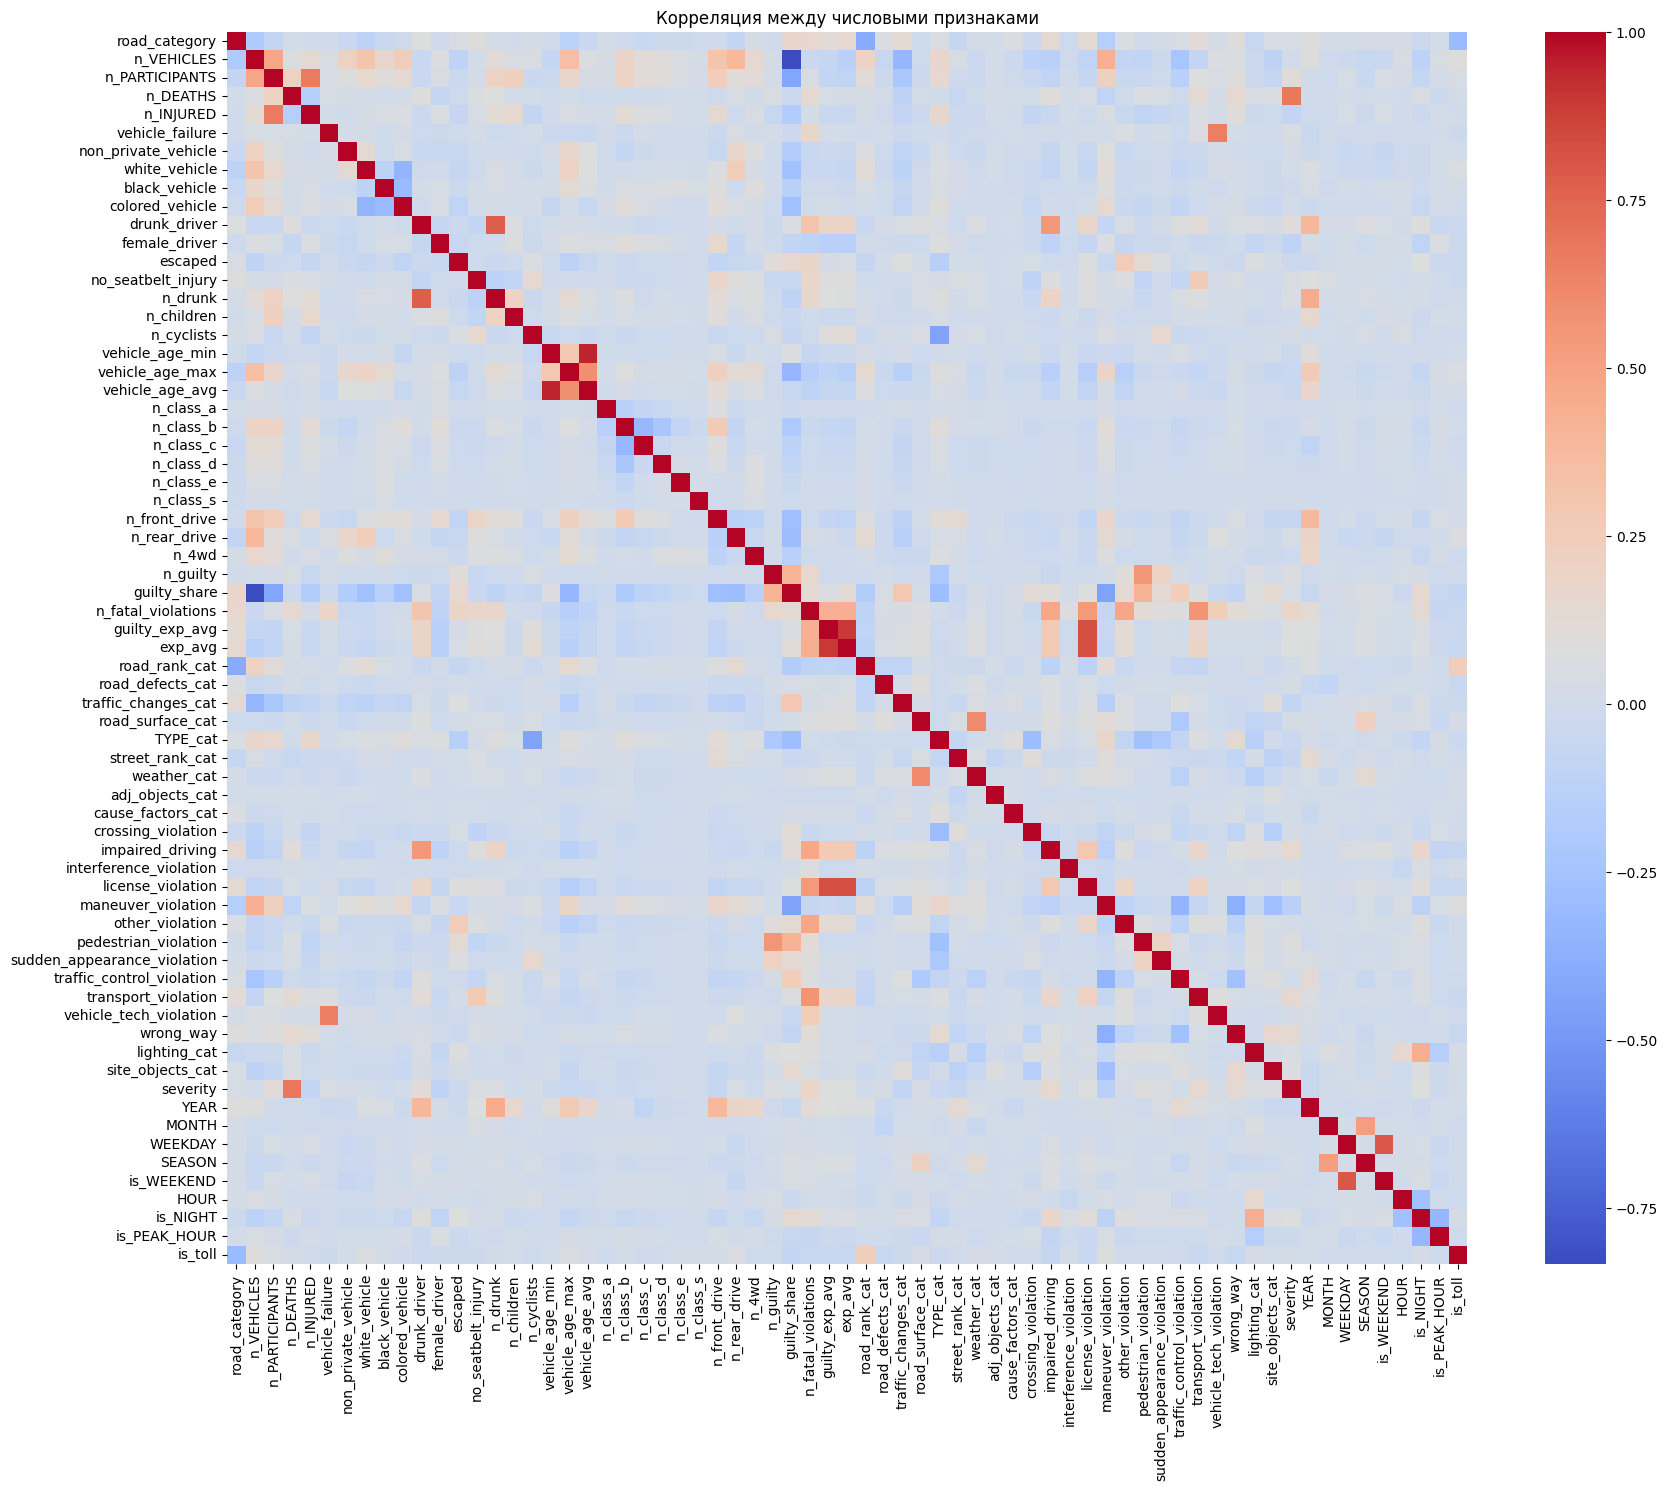

In [ ]:
meaningful_df = df_hypoth.drop(['REGION', 'ID', 'COORD_L', 'COORD_W', 'russian_vehicle', 'n_pedestrians'], axis=1)
corr_matrix = meaningful_df.corr(numeric_only=True)

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between numerical features")
plt.show()

It can be observed that there is a strong positive correlation between the features `'vehicle_age_min'` and `'vehicle_age_max'`, `'guilty_exp_avg'` and `'exp_avg'`, `'n_drunk'` and `'drunk_driver'`, `'license_violation'` with `'n_drunk'` and `'drunk_driver'`, and `'WEEKDAY'` and `'is_WEEKEND'`. There is also a moderate to strong correlation between `'severity'` and `'n_DEATHS'`, and between `'vehicle_tech_violation'` and `'vehicle_failure'`, among others. Additionally, a strong negative correlation exists between `'guilty_share'` and `'n_VEHICLES'`. However, it is important to take a closer look at the correlation between all features and extract those whose absolute value exceeds 0.5.

In [21]:
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(upper)

high_corr = corr_pairs.stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']

high_corr = high_corr[high_corr['Correlation'].abs() > 0.5]
high_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index)

print(high_corr)

                Feature1                Feature2  Correlation
987      vehicle_age_min         vehicle_age_avg     0.944598
1616      guilty_exp_avg                 exp_avg     0.897136
94            n_VEHICLES            guilty_share    -0.833200
1662             exp_avg       license_violation     0.830550
1629      guilty_exp_avg       license_violation     0.822163
2191             WEEKDAY              is_WEEKEND     0.798950
618         drunk_driver                 n_drunk     0.773074
248             n_DEATHS                severity     0.684722
132       n_PARTICIPANTS               n_INJURED     0.669315
367      vehicle_failure  vehicle_tech_violation     0.654224
1778    road_surface_cat             weather_cat     0.611941
1035     vehicle_age_max         vehicle_age_avg     0.589377
1601  n_fatal_violations     transport_violation     0.564393
1527            n_guilty    pedestrian_violation     0.563088
648         drunk_driver        impaired_driving     0.548836
1595  n_

The analysis of the correlation matrix revealed groups of features with high mutual correlation (|ρ| > 0.5), indicating the presence of multicollinearity. To eliminate its influence on subsequent modeling, a decision was made to remove certain features. In cases where two features reflected almost the same information, one was retained — the one that was more general or interpretable in the context of the task. For example, from the pair `'vehicle_age_min'` and `'vehicle_age_avg'`, only `'vehicle_age_avg'` was kept, as it better aggregates information about the age of vehicles. Similarly, `'exp_avg'` was retained instead of `'guilty_exp_avg'`, and `'guilty_share'` was kept instead of `'n_VEHICLES'`. In some cases, despite the correlation, both features were retained (e.g., `'road_surface_cat'` and `'weather_cat'`), as they logically described different aspects of the phenomenon and could carry independent value for the model. This approach helped reduce feature redundancy, decrease the risk of overfitting, and improve the stability of estimates without losing important information.

In [35]:
features_to_drop = [
    'vehicle_age_min',
    'vehicle_age_max',
    'guilty_exp_avg',
    'n_VEHICLES',
    'WEEKDAY',
    'n_drunk',
    'n_PARTICIPANTS',
    'vehicle_failure',
    'drunk_driver',
    'MONTH'
]

df_hypoth.drop(features_to_drop, axis=1, inplace=True)

In [39]:
meaningful_df = df_hypoth.drop(['REGION', 'ID', 'COORD_L', 'COORD_W', 'russian_vehicle', 'n_pedestrians'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])

In [40]:
vif = pd.DataFrame()
vif["feature"] = meaningful_df.columns
vif["VIF"] = [variance_inflation_factor(meaningful_df.values, i) for i in range(meaningful_df.shape[1])]

C:\Users\Настя\AppData\Local\Temp\ipykernel_1828\3810041898.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


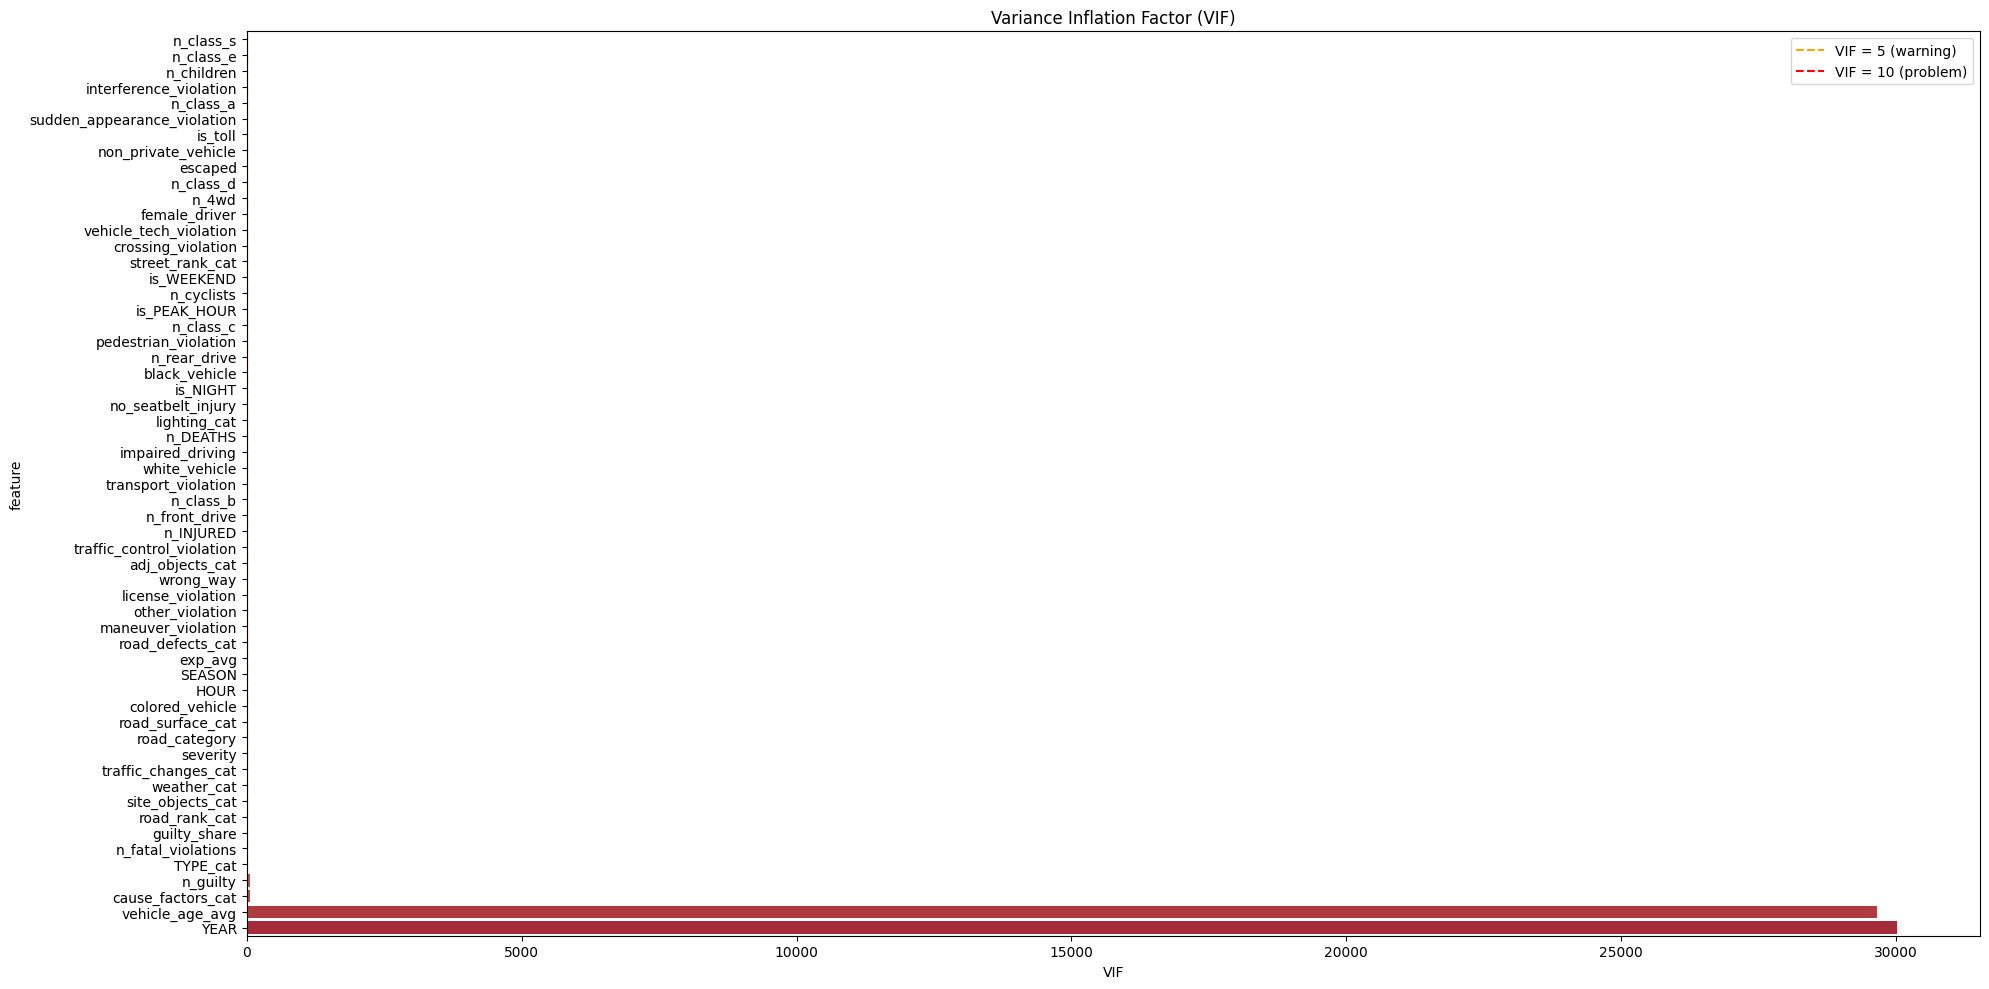

In [42]:
plt.figure(figsize=(20, 10))
sns.barplot(
    data=vif.sort_values(by="VIF", ascending=True),
    x="VIF",
    y="feature",
    palette="coolwarm"
)
plt.axvline(5, color='orange', linestyle='--', label='VIF = 5 (warning)')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (problem)')
plt.title("Variance Inflation Factor (VIF)")
plt.xlabel("VIF")
plt.ylabel("feature")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
features_to_drop = ['vehicle_age_avg', 'YEAR']
df_hypoth.drop(features_to_drop, axis=1, inplace=True)

In [44]:
meaningful_df = df_hypoth.drop(['REGION', 'ID', 'COORD_L', 'COORD_W', 'russian_vehicle', 'n_pedestrians'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])

vif = pd.DataFrame()
vif["feature"] = meaningful_df.columns
vif["VIF"] = [variance_inflation_factor(meaningful_df.values, i) for i in range(meaningful_df.shape[1])]

C:\Users\Настя\AppData\Local\Temp\ipykernel_1828\3810041898.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


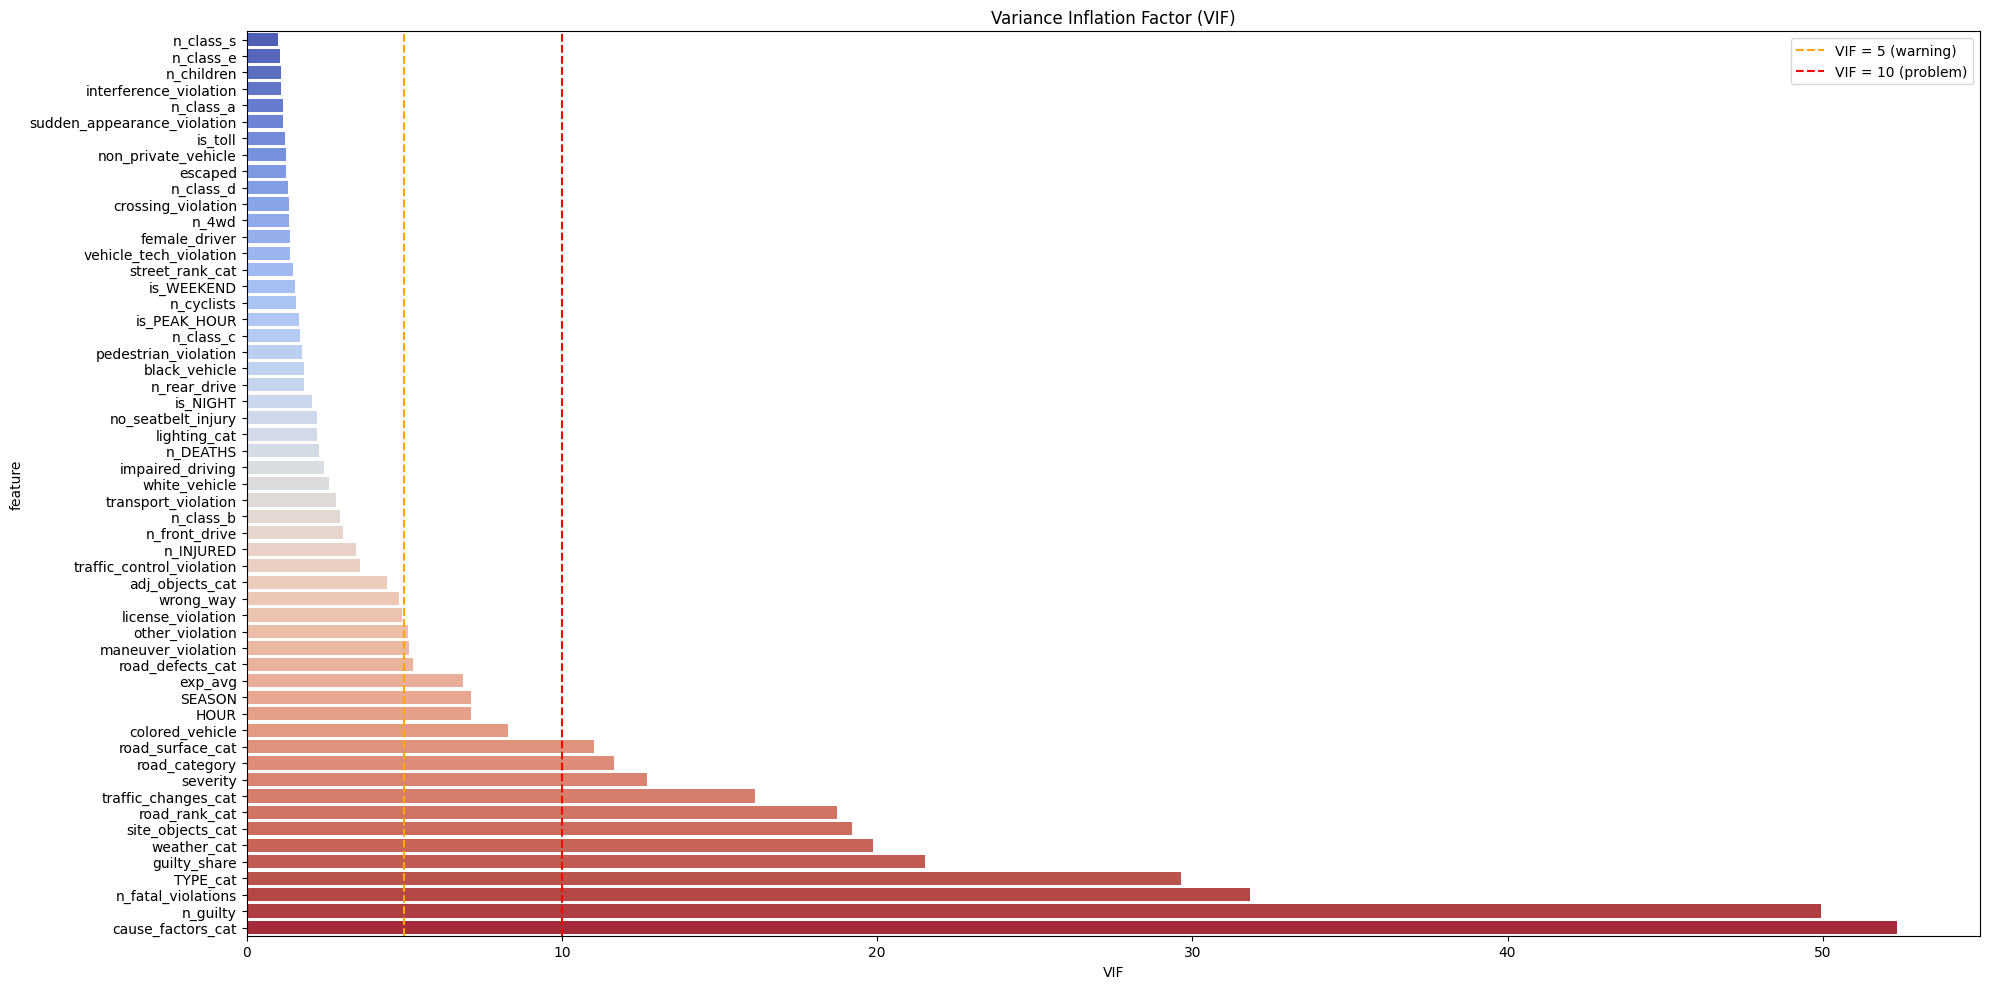

In [45]:
plt.figure(figsize=(20, 10))
sns.barplot(
    data=vif.sort_values(by="VIF", ascending=True),
    x="VIF",
    y="feature",
    palette="coolwarm"
)
plt.axvline(5, color='orange', linestyle='--', label='VIF = 5 (warning)')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (problem)')
plt.title("Variance Inflation Factor (VIF)")
plt.xlabel("VIF")
plt.ylabel("feature")
plt.legend()
plt.tight_layout()
plt.show()

The analysis of the VIF (Variance Inflation Factor) after preliminary feature filtering revealed the presence of variables with a high degree of multicollinearity. The features `cause_factors_cat` and `n_guilty` had VIF values significantly exceeding the acceptable threshold (over 50), indicating a high level of information redundancy and a risk of model instability. As a result, these features were removed. On the other hand, some features such as `guilty_share`, `n_fatal_violations`, and `weather_cat`, although they had elevated VIF values in the range of 15-30, were retained. This decision is justified by the fact that these features carry important domain-specific information for describing accidents, and their retention enhances the explanatory power of the model. Thus, only those features whose multicollinearity could significantly distort the modeling results were removed, while other important variables with an acceptable level of mutual dependence were kept.

In [47]:
features_to_drop = ['cause_factors_cat', 'n_guilty']

df_hypoth.drop(features_to_drop, axis=1, inplace=True)

## Multinomial Logit (MNL) regression

Let's talk about the different model specifications that we will use to test the hypotheses.

**1. Base Model (`severity ~ is_toll`)**  
The initial specification includes only the `is_toll` variable to assess its direct relationship with accident severity without the influence of other factors. This simple model provides insight into the "raw" effect of toll roads and tests whether there is a statistically significant difference between accidents on toll and free roads. Although the results of this model may be biased due to unaccounted variables, it serves as an important starting point for hypothesis testing.

**2. Geographic and Road Specifications (`+ road_category + road_rank_cat + site_objects_cat + adj_objects_cat`)**  
In the second model, we add road type and category characteristics, as well as objects located along the roads. These features are necessary to rule out situations where accident severity is explained not by the toll status of the road, but, for example, by a higher class of the road or the specifics of the road infrastructure. By controlling for these factors, we check whether the `is_toll` effect remains robust when considering the possible structural differences between toll and free roads.

**3. Incident Condition Model (`+ weather_cat + lighting_cat + road_surface_cat + ...`)**  
The third model controls for external conditions at the time of the accident: weather factors, lighting, road surface condition, seasonality, and time characteristics. These variables are directly related to the probability of severe outcomes and may be unevenly distributed between toll and free roads. By adding them to the model, we minimize the risk of misinterpreting the `is_toll` effect, for example, due to frequent night-time accidents or precipitation on certain types of roads.

**4. Behavioral Model (`+ license_violation + impaired_driving + ...`)**  
The fourth specification focuses on the behavior of the participants in the accidents and the consequences of the accidents themselves. Variables such as the presence of violations, impaired driving, and the number of casualties reflect the immediate causes of accident severity. If the `is_toll` variable remains significant even after including these features, it indicates that its influence is not mediated solely by driver behavior but has an independent effect.

**5. Full Model (all control variables)**  
The fifth model combines all the previous blocks of features into one specification, creating the most comprehensive and rigorous test of the hypothesis. This model allows us to evaluate whether the toll road effect persists after simultaneously controlling for geographic, behavioral, infrastructure, and weather conditions. If the `is_toll` variable remains statistically significant and positively correlated with accident severity, it suggests a strong and reliable effect, supporting the original hypothesis.

#### Class `'is_toll'` imbalance

Earlier, a class imbalance was found in the `'is_toll'` variable: the positive class makes up less than 7% of the entire dataset. Therefore, the results of hypothesis testing on such data will not be representative.  
To address the class imbalance problem, we will try three methods:

0. Without balancing
1. Balancing using undersampling  
2. Balancing using class weighting

### (0). Without balancing

In [61]:
formula1 = 'severity ~ is_toll'

model = smf.mnlogit(formula1, data=df_hypoth)
result = model.fit()

print('\n1. Base model:')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.028194
         Iterations 5

1. Base model:
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               440127
Model:                        MNLogit   Df Residuals:                   440123
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:               0.0001829
Time:                        14:53:32   Log-Likelihood:            -4.5254e+05
converged:                       True   LL-Null:                   -4.5262e+05
Covariance Type:            nonrobust   LLR p-value:                 1.118e-36
severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1258      0.003    -36.713      0.000      -0.133      -0.119
is_toll      

In [67]:
formula2 = 'severity ~ is_toll + road_category + road_rank_cat + site_objects_cat + adj_objects_cat + street_rank_cat'

model = smf.mnlogit(formula2, data=df_hypoth)
result = model.fit()

print('\n2. Geographical and road specification:\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.022535
         Iterations 6

2. Geographical and road specification:

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               440127
Model:                        MNLogit   Df Residuals:                   440113
Method:                           MLE   Df Model:                           12
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.005685
Time:                        14:58:00   Log-Likelihood:            -4.5005e+05
converged:                       True   LL-Null:                   -4.5262e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
      severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3973      0.026    -15.254     

In [66]:
formula3 = 'severity ~ is_toll + weather_cat + lighting_cat + road_surface_cat + traffic_changes_cat + is_NIGHT + is_PEAK_HOUR + is_WEEKEND + SEASON'

model = smf.mnlogit(formula3, data=df_hypoth)
result = model.fit()

print('\n3. Model of incident conditions:\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.018981
         Iterations 5

3. Model of incident conditions:

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               440127
Model:                        MNLogit   Df Residuals:                   440107
Method:                           MLE   Df Model:                           18
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.009142
Time:                        14:57:16   Log-Likelihood:            -4.4848e+05
converged:                       True   LL-Null:                   -4.5262e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
         severity=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1413      0.019     -7.539   

In [77]:
formula4 = 'severity ~ is_toll + wrong_way + pedestrian_violation + impaired_driving + maneuver_violation + traffic_control_violation + license_violation\
       + transport_violation + crossing_violation + interference_violation + sudden_appearance_violation + other_violation'

model = smf.mnlogit(formula4, data=df_hypoth)
result = model.fit()

print('\n4. Behavioral model:\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.990496
         Iterations 6

4. Behavioral model:

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               440127
Model:                        MNLogit   Df Residuals:                   440101
Method:                           MLE   Df Model:                           24
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.03684
Time:                        15:15:17   Log-Likelihood:            -4.3594e+05
converged:                       True   LL-Null:                   -4.5262e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2898      0.010  

In [ ]:
formula5 = (
    'severity ~ is_toll + road_category + road_rank_cat + site_objects_cat + adj_objects_cat\
    + weather_cat + lighting_cat + road_surface_cat + traffic_changes_cat + is_NIGHT + is_PEAK_HOUR + is_WEEKEND + SEASON\
    + wrong_way + pedestrian_violation + impaired_driving + maneuver_violation + traffic_control_violation + license_violation\
    + transport_violation + crossing_violation + interference_violation + sudden_appearance_violation + other_violation\
    + TYPE_cat + exp_avg + guilty_share + n_fatal_violations + n_INJURED'
)

model = smf.mnlogit(formula5, data=df_hypoth)
result = model.fit()

print('\n5. Full model (all control variables):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.937083
         Iterations 7

5. Full model (all control variables):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               440127
Model:                        MNLogit   Df Residuals:                   440067
Method:                           MLE   Df Model:                           58
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.08878
Time:                        15:22:55   Log-Likelihood:            -4.1244e+05
converged:                       True   LL-Null:                   -4.5262e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0

### (1). Undersampling

In [81]:
df_balanced = pd.concat([
    df_hypoth[df_hypoth['is_toll'] == 1],
    df_hypoth[df_hypoth['is_toll'] == 0].groupby('severity').apply(
        lambda x: x.sample(n=(df_hypoth[df_hypoth['is_toll'] == 1]['severity'] == x.name).sum(),
                          random_state=42)
    ).reset_index(drop=True)
])

Let's start the analysis by building a baseline model that includes the `'is_toll'` variable along with key factors related to the road environment and driver experience.

In [96]:
formula1 = 'severity ~ is_toll'

model = smf.mnlogit(formula1, data=df_balanced)
result = model.fit()

print('\n1. Base model (undersampling):')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.044202
         Iterations 5

1. Base model (undersampling):
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59076
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:               3.357e-11
Time:                        16:02:53   Log-Likelihood:                -61691.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     1.000
severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.013      0.658      0.511      -0.017       0.0

In [97]:
formula2 = 'severity ~ is_toll + road_category + road_rank_cat + site_objects_cat + adj_objects_cat + street_rank_cat'

model = smf.mnlogit(formula2, data=df_balanced)
result = model.fit()

print('\n2. Geographical and road specification (undersampling):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.039179
         Iterations 6

2. Geographical and road specification (undersampling):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59066
Method:                           MLE   Df Model:                           12
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.004810
Time:                        16:03:03   Log-Likelihood:                -61395.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                2.559e-119
      severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2710      0.078

In [98]:
formula3 = 'severity ~ is_toll + weather_cat + lighting_cat + road_surface_cat + traffic_changes_cat + is_NIGHT + is_PEAK_HOUR + is_WEEKEND + SEASON'

model = smf.mnlogit(formula3, data=df_balanced)
result = model.fit()

print('\n3. Model of incident conditions (undersampling):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.035996
         Iterations 5

3. Model of incident conditions (undersampling):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59060
Method:                           MLE   Df Model:                           18
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.007858
Time:                        16:03:25   Log-Likelihood:                -61207.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                2.191e-194
         severity=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0063      0.0

In [99]:
formula4 = 'severity ~ is_toll + wrong_way + pedestrian_violation + impaired_driving + maneuver_violation + traffic_control_violation + license_violation\
       + transport_violation + crossing_violation + interference_violation + sudden_appearance_violation + other_violation'

model = smf.mnlogit(formula4, data=df_balanced)
result = model.fit()

print('\n4. Behavioral model (undersampling):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.007633
         Iterations 6

4. Behavioral model (undersampling):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59054
Method:                           MLE   Df Model:                           24
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.03502
Time:                        16:03:53   Log-Likelihood:                -59531.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1

In [100]:
formula5 = (
    'severity ~ is_toll + road_category + road_rank_cat + site_objects_cat + adj_objects_cat\
    + weather_cat + lighting_cat + road_surface_cat + traffic_changes_cat + is_NIGHT + is_PEAK_HOUR + is_WEEKEND + SEASON\
    + wrong_way + pedestrian_violation + impaired_driving + maneuver_violation + traffic_control_violation + license_violation\
    + transport_violation + crossing_violation + interference_violation + sudden_appearance_violation + other_violation\
    + TYPE_cat + exp_avg + guilty_share + n_fatal_violations + n_INJURED'
)

model = smf.mnlogit(formula5, data=df_balanced)
result = model.fit()

print('\n5. Full model (undersampling):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.957191
         Iterations 6

5. Full model (undersampling):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                59080
Model:                        MNLogit   Df Residuals:                    59020
Method:                           MLE   Df Model:                           58
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.08333
Time:                        16:04:12   Log-Likelihood:                -56551.
converged:                       True   LL-Null:                       -61691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.7705   

### (2). Sample weights

In [89]:
sample_weights = compute_sample_weight(class_weight='balanced', y=df_hypoth['is_toll'])
df_weighted = df_hypoth.loc[df_hypoth.index.repeat(sample_weights.round().astype(int))]

In [93]:
X = df_weighted[['is_toll']]
X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\n1. Base model (sample weights):')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.032789
         Iterations 5

1. Base model (sample weights):
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617363
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:               0.0006478
Time:                        16:00:09   Log-Likelihood:            -6.3761e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                3.220e-180
severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1258      0.003    -36.713      0.000      -0.133      -0.

In [92]:
X = df_weighted[[
    'is_toll', 'road_category', 'road_rank_cat', 'site_objects_cat', 'adj_objects_cat'
]]
X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\n2. Geographical and road specification (sample weights):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.029209
         Iterations 6

2. Geographical and road specification (sample weights):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617355
Method:                           MLE   Df Model:                           10
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.004113
Time:                        15:58:51   Log-Likelihood:            -6.3540e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
      severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4287      0.02

In [94]:
X = df_weighted[[
    'is_toll', 'weather_cat', 'lighting_cat', 'road_surface_cat', 'traffic_changes_cat', 'is_NIGHT', 'is_PEAK_HOUR', 'is_WEEKEND', 'SEASON',
]]

X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\n3. Model of incident conditions (sample weights):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.024313
         Iterations 5

3. Model of incident conditions (sample weights):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617347
Method:                           MLE   Df Model:                           18
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.008850
Time:                        16:01:15   Log-Likelihood:            -6.3238e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
         severity=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1405      0.

In [95]:
X = df_weighted[[
    'is_toll', 'wrong_way', 'pedestrian_violation', 'impaired_driving', 'maneuver_violation', 'traffic_control_violation', 'license_violation',
    'transport_violation', 'crossing_violation', 'interference_violation', 'sudden_appearance_violation', 'other_violation'
]]
X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\n4. Behavioral model (sample weights):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.996435
         Iterations 6

4. Behavioral model (sample weights):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617341
Method:                           MLE   Df Model:                           24
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.03582
Time:                        16:02:25   Log-Likelihood:            -6.1517e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.

In [91]:
X = df_weighted[[
    'is_toll', 'road_category', 'road_rank_cat', 'site_objects_cat', 'adj_objects_cat',
    'weather_cat', 'lighting_cat', 'road_surface_cat', 'traffic_changes_cat', 'is_NIGHT', 'is_PEAK_HOUR', 'is_WEEKEND', 'SEASON',
    'wrong_way', 'pedestrian_violation', 'impaired_driving', 'maneuver_violation', 'traffic_control_violation', 'license_violation',
    'transport_violation', 'crossing_violation', 'interference_violation', 'sudden_appearance_violation', 'other_violation',
    'TYPE_cat', 'exp_avg', 'guilty_share', 'n_fatal_violations', 'n_INJURED'
]]

X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\n5. Full model (sample weights):\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.946009
         Iterations 7

5. Full model (sample weights):

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               617367
Model:                        MNLogit   Df Residuals:                   617307
Method:                           MLE   Df Model:                           58
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.08462
Time:                        15:57:28   Log-Likelihood:            -5.8403e+05
converged:                       True   LL-Null:                   -6.3802e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.7662  

In models without accounting for class imbalance, the variable `'is_toll'` shows a positive and statistically significant effect on accident severity across all specifications, which supports the hypothesis. When using sample weights, the effect remains stable and even strengthens, which indicates the reliability of the obtained result. In the case of applying undersampling, instability is observed: in one specification, the effect becomes negative and significant, while in others it becomes insignificant. This behavior can be explained by the loss of information due to the artificial reduction of the majority class (`'is_toll'` = 0). Given the overall stability of the result in the full and weighted approaches, the **hypothesis 2.1. of more severe consequences of accidents on toll roads receives empirical confirmation**.

### Separate models

We will evaluate the same for toll roads and free roads separately. There is a chance that the models will differ in terms of the significance and direction of the influence of factors.

In [103]:
df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_toll.drop(['is_toll'], axis=1, inplace=True)

df_free = df_hypoth[df_hypoth['is_toll'] == 0]
df_free.drop(['is_toll'], axis=1, inplace=True)

In [108]:
X = df_toll[[
    'road_category', 'road_rank_cat', 'site_objects_cat', 'adj_objects_cat',
    'weather_cat', 'lighting_cat', 'road_surface_cat', 'traffic_changes_cat', 'is_NIGHT', 'is_PEAK_HOUR', 'is_WEEKEND', 'SEASON',
    'wrong_way', 'pedestrian_violation', 'impaired_driving', 'maneuver_violation', 'traffic_control_violation', 'license_violation',
    'transport_violation', 'crossing_violation', 'interference_violation', 'sudden_appearance_violation', 'other_violation',
    'TYPE_cat', 'exp_avg', 'guilty_share', 'n_fatal_violations', 'n_INJURED'
]]

X = sm.add_constant(X)

y = df_toll['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\nFull model for toll roads:\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.964786
         Iterations 6

Full model for toll roads:

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:                29540
Model:                        MNLogit   Df Residuals:                    29482
Method:                           MLE   Df Model:                           56
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.07605
Time:                        18:41:37   Log-Likelihood:                -28500.
converged:                       True   LL-Null:                       -30846.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.5346      0

In [110]:
X = df_free[[
    'road_category', 'road_rank_cat', 'site_objects_cat', 'adj_objects_cat',
    'weather_cat', 'lighting_cat', 'road_surface_cat', 'traffic_changes_cat', 'is_NIGHT', 'is_PEAK_HOUR', 'is_WEEKEND', 'SEASON',
    'wrong_way', 'pedestrian_violation', 'impaired_driving', 'maneuver_violation', 'traffic_control_violation', 'license_violation',
    'transport_violation', 'crossing_violation', 'interference_violation', 'sudden_appearance_violation', 'other_violation',
    'TYPE_cat', 'exp_avg', 'guilty_share', 'n_fatal_violations', 'n_INJURED'
]]

X = sm.add_constant(X)

y = df_free['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print('\nFull model for free roads:\n')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.934725
         Iterations 7

Full model for free roads:

                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               410587
Model:                        MNLogit   Df Residuals:                   410529
Method:                           MLE   Df Model:                           56
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                 0.08989
Time:                        19:16:08   Log-Likelihood:            -3.8379e+05
converged:                       True   LL-Null:                   -4.2169e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.7573      0

**Conclusions.**

# Machine Learning

## Testing the hypotheses

In [111]:
df_hypoth.columns

Index(['REGION', 'DATE', 'COORD_L', 'COORD_W', 'road_name', 'road_category',
       'ID', 'n_DEATHS', 'n_INJURED', 'non_private_vehicle', 'russian_vehicle',
       'white_vehicle', 'black_vehicle', 'colored_vehicle', 'female_driver',
       'escaped', 'no_seatbelt_injury', 'n_children', 'n_cyclists',
       'n_pedestrians', 'n_class_a', 'n_class_b', 'n_class_c', 'n_class_d',
       'n_class_e', 'n_class_s', 'n_front_drive', 'n_rear_drive', 'n_4wd',
       'guilty_share', 'n_fatal_violations', 'exp_avg', 'road_rank_cat',
       'road_defects_cat', 'traffic_changes_cat', 'road_surface_cat',
       'TYPE_cat', 'street_rank_cat', 'weather_cat', 'adj_objects_cat',
       'crossing_violation', 'impaired_driving', 'interference_violation',
       'license_violation', 'maneuver_violation', 'other_violation',
       'pedestrian_violation', 'sudden_appearance_violation',
       'traffic_control_violation', 'transport_violation',
       'vehicle_tech_violation', 'wrong_way', 'lighting_cat',
     

In [ ]:
df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_free = df_hypoth[df_hypoth['is_toll'] == 0]

drop_features = [
    'severity',
    'n_DEATHS',
    'n_INJURED',
    'road_name',
    'DATE',
    'ID',
    'COORD_L', 
    'COORD_W'
]

features = [col for col in df_hypoth.columns if col not in drop_features]

X_toll = df_toll[features]
y_toll = df_toll['severity']
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free['severity']
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

rf_toll = RandomForestClassifier(random_state=42)
rf_toll.fit(X_train_toll, y_train_toll)

rf_free = RandomForestClassifier(random_state=42)
rf_free.fit(X_train_free, y_train_free)

RandomForestClassifier(random_state=42)

In [113]:
X_num_toll = X_toll.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
X_scaled_toll = scaler.fit_transform(X_num_toll)
pca = PCA(n_components=2)
X_pca_toll = pca.fit_transform(X_scaled_toll)

X_num_free = X_free.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
X_scaled_free = scaler.fit_transform(X_num_free)
pca = PCA(n_components=2)
X_pca_free = pca.fit_transform(X_scaled_free)

Let's choose the most important fearures for analysis.

In [114]:
threshold = 0.01

# -------------------

importances_toll = rf_toll.feature_importances_
feature_names = X_toll.columns

importances_df_toll = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_toll
})

# filter out unimportant features except 'is_toll'
low_importance_features = importances_df_toll[
    (importances_df_toll['importance'] < threshold) & 
    (importances_df_toll['feature'] != 'is_toll')
]['feature'].tolist()

X_toll_filtered = X_toll.drop(columns=low_importance_features)

# -------------------

importances_free = rf_free.feature_importances_
feature_names = X_free.columns

importances_df_free = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_free
})

low_importance_features = importances_df_free[
    (importances_df_free['importance'] < threshold) & 
    (importances_df_free['feature'] != 'is_toll')
]['feature'].tolist()

X_free_filtered = X_free.drop(columns=low_importance_features)

In [115]:
y_toll = df_toll['severity'] - 1
y_free = df_free['severity'] - 1

xgb_toll = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_toll.fit(X_toll_filtered, y_toll)

xgb_free = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_free.fit(X_free_filtered, y_free)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [116]:
proba_toll = xgb_toll.predict_proba(X_toll_filtered)
proba_free = xgb_free.predict_proba(X_free_filtered)

avg_proba_toll = np.mean(proba_toll, axis=0)
avg_proba_free = np.mean(proba_free, axis=0)

print("Toll roads vs free roads\n")
print(f"'Light' severity:  {avg_proba_toll[0]:3f} | {avg_proba_free[0]:3f}")
print(f"'Medium' severity:  {avg_proba_toll[1]:3f} | {avg_proba_free[1]:3f}")
print(f"'Severe' severity:  {avg_proba_toll[2]:3f} | {avg_proba_free[2]:3f}")

Toll roads vs free roads

'Light' severity:  0.405521 | 0.442592
'Medium' severity:  0.408894 | 0.390171
'Severe' severity:  0.185585 | 0.167231


To test the hypothesis, an XGBoost model trained to predict the severity of accidents was also used. Calculation of the average probabilities of classes by subsamples showed that the probability of a severe outcome (`medium` and `severe`) on toll roads is higher (`0.408` versus `0.39` and `0.186` versus `0.167`), which **corresponds to the hypothesis 2.1**. The result was obtained with all other things being equal, which further confirms the stability of the differences.

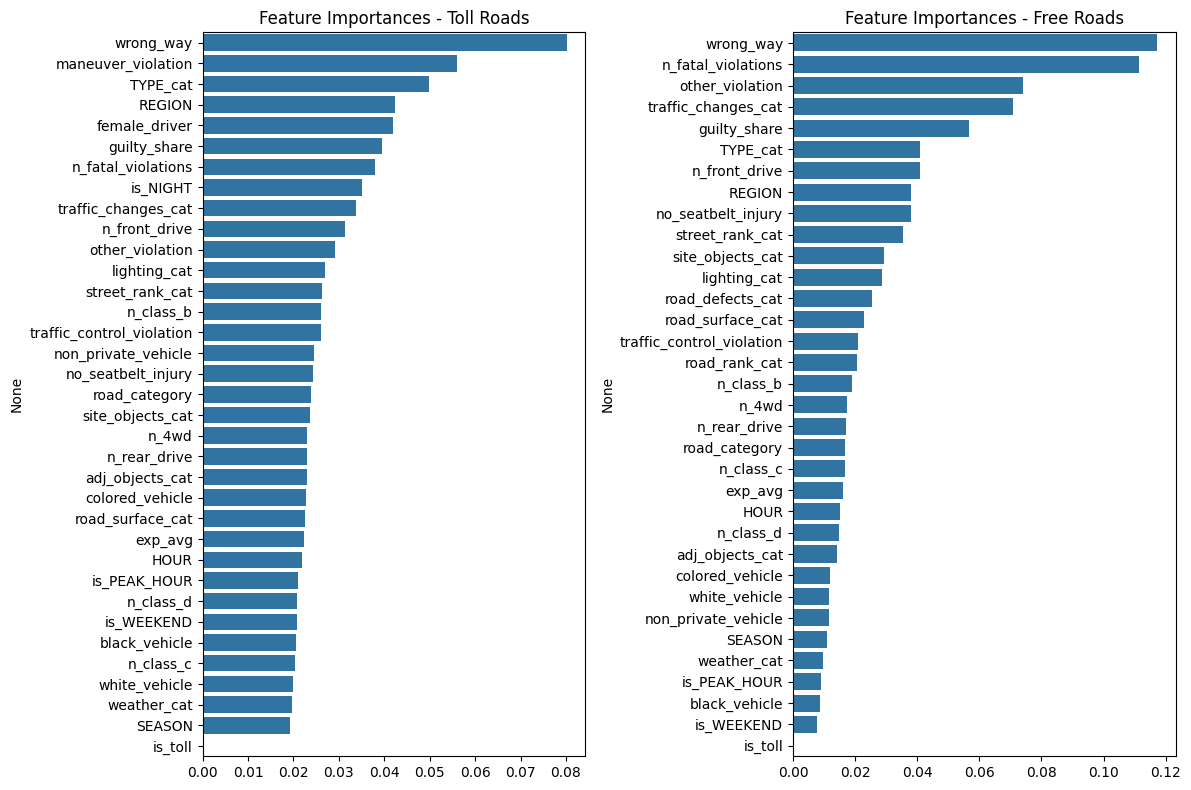

In [117]:
# Feature importances
importances_toll = pd.Series(xgb_toll.feature_importances_, index=X_toll_filtered.columns).sort_values(ascending=False)
importances_free = pd.Series(xgb_free.feature_importances_, index=X_free_filtered.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()

The comparison of feature importance between models trained separately on data for toll and free roads confirms that **the mechanisms determining accident severity differ depending on the road type**. For example, on **toll roads**, features such as `maneuver_violation`, `female_driver`, `REGION`, and `TYPE_cat` are highly significant, while on **free roads**, the top important features include `n_fatal_violations`, `other_violation`, `traffic_changes_cat`, and `road_defects_cat`. Notably, the variable `wrong_way` consistently ranks first in both cases, which could suggest its universal influence, but the rest of the feature profile is different. It is also worth noting that the variable `is_toll` has minimal importance in both models, which makes sense since the data is already split by this feature, and the model should not extract additional information from it.

Thus, the observed differences in feature importance structure **confirm hypothesis 2.2**, which posits that the factors influencing the severity of traffic accidents differ depending on the type of road infrastructure.

## Model predicting crash severity

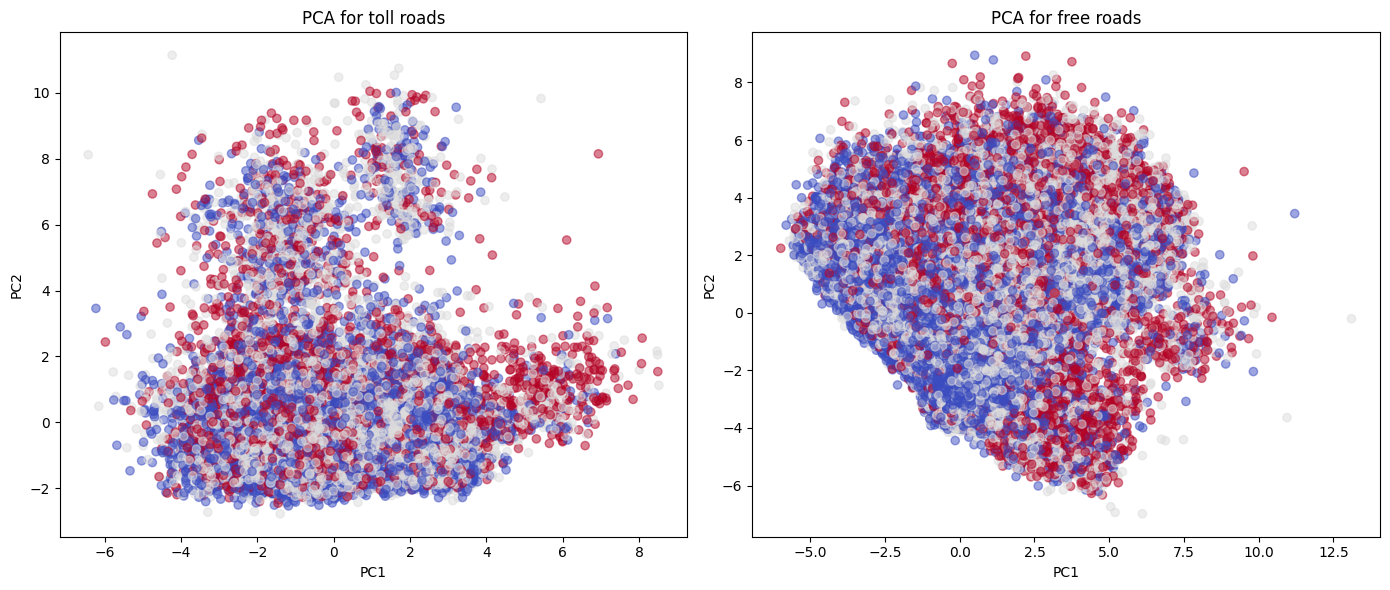

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca_toll[:,0], X_pca_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)
axes[0].set_title("PCA for toll roads")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca_free[:,0], X_pca_free[:,1], c=y_free, cmap='coolwarm', alpha=0.5)
axes[1].set_title("PCA for free roads")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

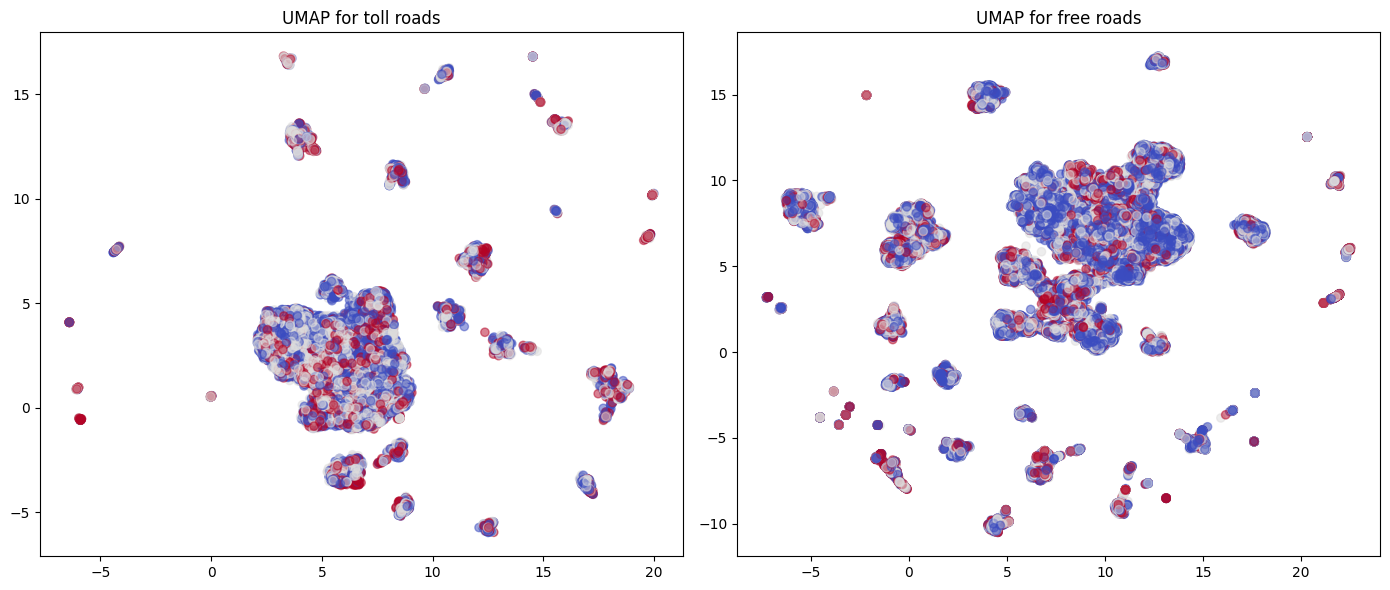

In [51]:
reducer = umap.UMAP()
X_umap_toll = reducer.fit_transform(X_scaled_toll)

reducer = umap.UMAP()
X_umap_free = reducer.fit_transform(X_scaled_free)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_umap_toll[:,0], X_umap_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)
axes[0].set_title("UMAP for toll roads")

axes[1].scatter(X_umap_free[:,0], X_umap_free[:,1], c=y_free, cmap='coolwarm', alpha=0.5)
axes[1].set_title("UMAP for free roads")

plt.tight_layout()
plt.show()

Visualization of the data using dimensionality reduction methods such as PCA and UMAP reveals that observations with varying accident severity (`'severity'`) heavily overlap in the feature space, both on toll and free roads. This suggests that the severity classes are poorly separable: they do not form distinct clusters and lack clear boundaries between them. This weak structuring may be due to several factors: firstly, the severity feature might depend on complex interactions between factors that are not captured by simple projections. Secondly, the data are real-world data, which could be too noisy for accurately predicting the severity class of an accident.

Nevertheless, even with visual inseparability, it is still worth attempting to achieve acceptable performance in predicting `'severity'`. We will evaluate the performance of different models for the task of predicting accident severity and also investigate whether feature engineering and parameter tuning can lead to improved accuracy and help identify significant factors influencing the outcome of accidents.